<a href="https://colab.research.google.com/github/wjtopp3/CSIT-2033/blob/main/CSIT_2033_Week_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

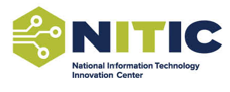

# Summer Working Connections May 2025
## Secure Programming with Python

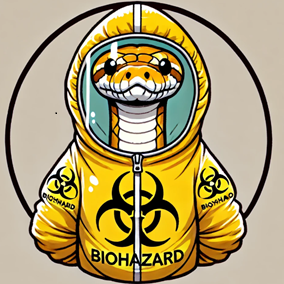

### Prof. Pamela Brauda and David Singletary
### Florida State College at Jacksonville

# Day 3: Cryptography, APIs, and Static Analysis
1. Implementing Cryptography with Python
2. Securing APIs
3. Detecting Vulnerabilities using Static Analysis Tools



# 1. Implementing Cryptography with Python

 - # Encryption and Decryption of Sensitive Data

- The modern developer's encryption toolbox consists of a modest collection of basic tools.
- The following list enumerates the basic crypto security functions and describes what each does, as well as what the security of each depends on:
  - **Random numbers** are useful as padding and nonces(*), but only if they are unpredictable.
  - **Message digests** (hash functions) serve as a fingerprint of data, but only if impervious to collisions.
  - **Symmetric encryption** conceals data based on a secret key the parties share.
  - **Asymmetric encryption** conceals data based on a secret the recipient knows.
  - **Digital signatures** authenticate data based on a secret only the signer knows.
  - **Digital certificates** authenticate signers based on trust in a root certificate.
  - **Key exchange** allows two parties to establish a shared secret over an open channel, despite eavesdropping.
- [1] Kohnfelder Ch. 5
-\* a **nonce** (short for "number used once") is a random value used to ensure that old communications cannot be reused in replay attacks, and to add unpredictability to encryption operations.

# 🛠️ Hands-On: Encrypt and Decrypt a Message

In [ ]:
# 1: Random nonce         — Ensure unpredictable values for operations
# 2: Hash message         — Create secure, fixed-size data fingerprint
# 3: Symmetric encrypt    — Encrypt with a shared secret
# 4: Asymmetric encrypt   — Encrypt with public/private key pairs
# 5: Digital signature    — Authenticate sender’s identity and message integrity
# 6: Signature verify     — Confirm that signature is authentic
# 7: Key exchange         — Establish a new shared secret without prior sharing

from cryptography.fernet import Fernet
from cryptography.hazmat.primitives import hashes, serialization
from cryptography.hazmat.primitives.asymmetric import rsa, padding
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives.asymmetric.utils import Prehashed
from cryptography.hazmat.backends import default_backend
import os
import secrets

# 1
nonce = secrets.token_bytes(16)  # 16-byte random nonce
print("Random Nonce:", nonce.hex())

# 2
message = b"Confidential data"
digest = hashes.Hash(hashes.SHA256())
digest.update(message)
message_hash = digest.finalize()
print("SHA-256 Digest:", message_hash.hex())

# 3
symmetric_key = Fernet.generate_key()
cipher = Fernet(symmetric_key)

encrypted_message = cipher.encrypt(message)
print("Symmetrically Encrypted Message:", encrypted_message)

decrypted_message = cipher.decrypt(encrypted_message)
print("Decrypted Symmetric Message:", decrypted_message.decode())

# 4
private_key = rsa.generate_private_key(public_exponent=65537, key_size=2048)
public_key = private_key.public_key()

encrypted_with_public = public_key.encrypt(
    message,
    padding.OAEP(
        mgf=padding.MGF1(algorithm=hashes.SHA256()),
        algorithm=hashes.SHA256(),
        label=None
    )
)
print("Asymmetrically Encrypted Message:", encrypted_with_public.hex())

decrypted_with_private = private_key.decrypt(
    encrypted_with_public,
    padding.OAEP(
        mgf=padding.MGF1(algorithm=hashes.SHA256()),
        algorithm=hashes.SHA256(),
        label=None
    )
)
print("Decrypted Asymmetric Message:", decrypted_with_private.decode())

# 5
signature = private_key.sign(
    message,
    padding.PSS(
        mgf=padding.MGF1(hashes.SHA256()),
        salt_length=padding.PSS.MAX_LENGTH
    ),
    hashes.SHA256()
)
print("Digital Signature:", signature.hex())

# 6
try:
    public_key.verify(
        signature,
        message,
        padding.PSS(
            mgf=padding.MGF1(hashes.SHA256()),
            salt_length=padding.PSS.MAX_LENGTH
        ),
        hashes.SHA256()
    )
    print("Signature Verified Successfully!")
except Exception as e:
    print("Signature Verification Failed:", e)

# skip digital certificates (trust chains)
# this would need a real X.509 certificate authority setup (bigger project!)

# 7.do key exchange (Elliptic Curve Diffie-Hellman - ECDH)
# Simulate two parties generating shared secret

# Party A key pair
party_a_private_key = ec.generate_private_key(ec.SECP384R1())
party_a_public_key = party_a_private_key.public_key()

# Party B key pair
party_b_private_key = ec.generate_private_key(ec.SECP384R1())
party_b_public_key = party_b_private_key.public_key()

# Each party computes the shared secret
shared_secret_a = party_a_private_key.exchange(ec.ECDH(), party_b_public_key)
shared_secret_b = party_b_private_key.exchange(ec.ECDH(), party_a_public_key)

# Confirm that both shared secrets match
print("Shared Secret A:", shared_secret_a.hex())
print("Shared Secret B:", shared_secret_b.hex())
print("Shared secrets match:", shared_secret_a == shared_secret_b)


# Choosing Secure Cryptographic Libraries
- Cryptographic libraries are used in software development to securely implement encryption, decryption, authentication, digital signatures, and data integrity checks.
  - Selecting the right libraries is critical to building secure applications.
  - OWASP provides guidelines for identifying trusted libraries at https://top10proactive.owasp.org/the-top-10/c6-use-secure-dependencies/#implementation  
- Python librariy specifics:
  1. Use established libraries that are widely trusted and have been subject to external audits, such as **cryptography** (the "official" Python cryptography package https://cryptography.io/en/latest/), **PyNaCl** (Python binding to libsodium, a high-level cryptography library), or **PyCryptodome** (a fork of the now-legacy PyCrypto, with active maintenance)
  2. Avoid outdated or deprecated libraries like **PyCrypto** (no longer maintained) or custom, hand-rolled cryptography code with potentially unresolved vulnerabilities.
  3. Libraries should have a history of frequent updates, security patches, and responsiveness to vulnerability reports.
  4. Use simple, high-level cryptographic APIs (like Fernet from cryptography.fernet) instead of directly managing low-level primitives like block ciphers and key scheduling.
  5. Verify the library’s license (e.g., Apache 2.0, BSD) fits within your project’s legal and operational requirements.
  6. Well-documented libraries with active communities are easier to use securely, reducing the chance of misuse or configuration mistakes.

# Secure Hashing and Integrity Checks

- Hashing is a cryptographic process that converts data into a fixed-length string (digest), uniquely representing the input.
  - Secure hash functions (like SHA-256) are designed to be collision-resistant, fast, and irreversible.
  - A hash **collision** is a random match in hash values that occurs when a hashing algorithm produces the same hash value for two distinct pieces of data, e.g.,

```
hash1
         -> 9F86D081884C7D659A2FEAA0C55A...
hash2
```

  - Probability of a collision using SHA256 is = 1 in 2<sup>256</sup> (≈ 1.2 × 1077)
  - No efficient algorithm is known to construct sequences with the same hash value
  - **Quantum computers** could exploit SHA-256 vulnerabilities by reversing the hashing process
- Integrity checks are used to verify that data has not been tampered with or corrupted.
  - A newly computed hash of received data can be compared to a previously known good hash.
- Any change to the original input (even a single bit) produces a drastically different output.

# 🛠️ Hands-On: Verify File Integrity Using SHA-256 Hashing

In [ ]:
import hashlib

# create a sample file to hash
with open("example.txt", "w") as f:
    f.write("This is some test content for hashing.\n")

# define the secure hash function
def hash_file(filepath):
    hasher = hashlib.sha256()
    with open(filepath, 'rb') as f:
        for chunk in iter(lambda: f.read(4096), b''):
            hasher.update(chunk)
    return hasher.hexdigest()

# hash the file initially
original_hash = hash_file("example.txt")

# re-hash the file to simulate checking for integrity
current_hash = hash_file("example.txt")

print(original_hash)
print(current_hash)

# compare hashes to verify integrity
if original_hash == current_hash:
    print("File integrity verified.")
else:
    print("File has been altered or corrupted.")

# Complete Day 3 Exercise 1 Here
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FSCJ-FacultyDev/SWC-Columbus-2025/blob/main/exercises/Day3Exercise1_FileHashValidation.ipynb)



# 4. Key Management and Storage

<img src="https://raw.githubusercontent.com/FSCJ-FacultyDev/SWC-Columbus-2025/main/images/day3-key.png">

- Managing and storing cryptographic keys securely is just as critical as the algorithms themselves.
  - Poor key management can render even the most robust encryption ineffective.
- In Python, cryptographic keys may be symmetric (e.g., used with AES) or asymmetric (e.g., public/private RSA or ECC key pairs).
- Regardless of the type, keys must be generated using cryptographically secure random number generators (e.g., secrets or os.urandom) and stored in a way that prevents unauthorized access, while still allowing legitimate use within the application.

- The cryptography, PyCryptodome, and Fernet libraries described in the "Choosing Secure Cryptographic Libraries" section above provide secure ways to generate, serialize, and deserialize keys.
  - **cryptography** supports key serialization to PEM or DER formats for both symmetric and asymmetric keys. Private keys can be optionally encrypted with a password during export.
  - **PyCryptodome** supports raw and standard formats (e.g., PEM for RSA/ECC). Private keys can be encrypted using passphrases with PKCS#8. Also supports key wrapping for secure key transport and exchange.
  - **Fernet** uses fixed-format, URL-safe Base64-encoded 32-byte symmetric keys that are not serialized in PEM/DER formats and are typically stored in secure files or environment variables.
- Keys should never be hardcoded in source code or stored in plaintext configuration files; instead, they can be encrypted and stored in environment variables, secure key vaults (like AWS KMS or HashiCorp Vault), or protected OS-specific keyrings.

# 🛠️ Hands-On: Manage a Symmetric Encryption Key Using Fernet

In [ ]:
from cryptography.fernet import Fernet

# Generate a key and write it to a file
key = Fernet.generate_key()
with open("secret.key", "wb") as key_file:
    key_file.write(key)

# To use the key later, read it back securely and initialize the cipher object:

# Load the key
with open("secret.key", "rb") as key_file:
    key = key_file.read()

cipher = Fernet(key)

# Best Practices

- Best practices include periodically rotating keys and revoking compromised ones.
  - Implementing key rotation involves encrypting data with a new key and optionally decrypting-reencrypting older data, or maintaining a key versioning scheme.
  - In a production-grade system, it is often beneficial to separate key management from application logic entirely by delegating to hardware security modules (HSMs) or managed services.
  - For local development and learning purposes, securing file permissions and avoiding plaintext exposure are key steps toward better cryptographic hygiene.

# Hardware Security Modules (HSMs)

<img src="https://raw.githubusercontent.com/FSCJ-FacultyDev/SWC-Columbus-2025/main/images/day3-hsm.png">

- HSMs are physical devices designed to protect and manage digital keys and perform cryptographic operations within a tamper-resistant environment.
  - AWS CloudHSM (https://aws.amazon.com/cloudhsm) a cloud-based HSM service from Amazon that provides dedicated HSM appliances within AWS infrastructure.
  - Azure Dedicated HSM (https://azure.microsoft.com/en-us/products/azure-dedicated-hsm) a managed HSM offering deployed in Azure data centers.
  - Google Cloud HSM (https://cloud.google.com/kms/docs/hsm) a cloud-native HSM that integrates with Google Cloud's KMS (see below).


# Key Management Services
- KMS are cloud-based or on-premises services designed to securely create, store, manage, and control access to cryptographic keys, often integrating with applications and infrastructure to simplify encryption and compliance.
  - AWS Key Management Service (https://aws.amazon.com/kms/) - integrates with other AWS services and optionally backs keys with AWS CloudHSM.
  - Azure Key Vault (https://azure.microsoft.com/en-us/products/key-vault) - a  centralized cloud service for managing keys, secrets, and certificates, optionally backed by HSMs.
  - Google Cloud Key Management Service (https://cloud.google.com/security/products/security-key-management) - manages encryption keys for Google Cloud projects with various levels of protection, including Cloud HSM integration.
  - HashiCorp Vault (https://www.hashicorp.com/en/products/vault) - a popular open-source and enterprise tool for managing secrets and protecting sensitive data using software-based encryption and optional HSM support (integrated - does not provide it's own HSM)

# Digital Signatures and Authentication

- Digital signatures are a cornerstone of modern cryptographic authentication
- They provide a way to ensure that a message or document genuinely comes from a trusted source and has not been altered in transit.
- Unlike handwritten signatures, which can be forged or copied, digital signatures rely on mathematical algorithms and cryptographic key pairs—specifically asymmetric encryption.
- The sender signs a message with their private key, and the recipient verifies the signature using the sender’s public key.
- This mechanism guarantees both integrity and authenticity.

# Authentication Using Digital Signatures

- Using digital signatures for authentication is common in secure communications protocols such as TLS, S/MIME, and digital certificates in PKI (Public Key Infrastructure).
- When a signed message is received, the recipient can verify its origin and confirm that the message content hasn't changed.
- This is useful for validating code (e.g., software binaries), securing email, and authenticating identity in blockchain transactions or secure APIs.

- In Python, digital signatures can be implemented using libraries like cryptography or PyCryptodome.
- Using **cryptography**, you can generate an RSA key pair, sign a message with the private key, and verify the signature with the public key.

# 🛠️ Hands-On: Generate RSA Keys, Sign Message, Verify Signature

In [ ]:
from cryptography.hazmat.primitives.asymmetric import rsa, padding
from cryptography.hazmat.primitives import hashes

# Generate RSA keys
private_key = rsa.generate_private_key(public_exponent=65537, key_size=2048)
public_key = private_key.public_key()
print("RSA key pair generated.")

# Sign a message
message = b"Verify me"
signature = private_key.sign(
    message,
    padding.PSS(
        mgf=padding.MGF1(hashes.SHA256()),
        salt_length=padding.PSS.MAX_LENGTH
    ),
    hashes.SHA256()
)
print(f"Message signed: {message.decode()}")
print(f"Signature (hex): {signature.hex()}")

# Verify the signature
try:
    public_key.verify(
        signature,
        message,
        padding.PSS(
            mgf=padding.MGF1(hashes.SHA256()),
            salt_length=padding.PSS.MAX_LENGTH
        ),
        hashes.SHA256()
    )
    print("Signature is valid. Message is authentic and unchanged.")
except Exception as e:
    print("Signature verification failed:", str(e))


## A NOTE on Private Key Generation

```
private_key = rsa.generate_private_key(public_exponent=65537, key_size=2048)
```

The arguments **public_exponent** and **key_size** are critical to how the RSA key pair is generated and how secure and efficient it will be.

- public_exponent=65537
  - This is the RSA public exponent **e**, a value used in the exponentiation step of the encryption. There is also a private exponent **d** which is hidden and calculated from e.
  - It must be an odd integer greater than 1.
  - 65537 is a widely used standard value because it strikes a balance between security and performance.
  - 65537 is prime and has only two bits set (binary: 10000000000000001), making exponentiation efficient.
  - Larger values are slower.
  - Smaller values have had historical vulnerabilities.
- key_size=2048
  - This defines the bit length of the RSA modulus, which determines the overall strength of the key.
  - A 2048-bit key means the modulus (a large calculated value included in both the public and private keys) is a product of two 1024-bit primes.

# Complete Day 3 Exercise 2 Here
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FSCJ-FacultyDev/SWC-Columbus-2025/blob/main/exercises/Day3Exercise2_RSASignatureValidation.ipynb)

## Differences between Simple Hashing and RSA Signature Validation
| **Feature**     | **Hashing**                                | **Digital Signing with RSA**                                |
|-----------------|---------------------------------------------|--------------------------------------------------------------|
| **What it does**| Creates a unique fingerprint of data        | Authenticates and proves the origin and integrity of data     |
| **Use case**    | Detect changes to data                      | Verify the sender’s identity and detect changes to data       |

# Using Signatures for Non-Repudiation
- **Non-repudiation** is a security principle that ensures a party in a communication cannot deny the authenticity of their signature, message, or action.
  - It provides proof of origin and integrity that can be verified by a third party, and is commonly implemented using digital signatures and cryptographic certificates.
  - When a user signs a document with their private key, anyone with the corresponding public key can verify that the signature is valid and came from that user.
    - Since the private key is known only to the signer, they cannot later claim they didn't sign it—this is the essence of non-repudiation.
  - It is widely used in:
    - Electronic contracts and legal documents
    - Secure email (e.g., with S/MIME or PGP)
    - Software distribution to verify trusted sources
    - Blockchain transactions to prove ownership or consent
  - Beyond simple message authentication, digital signatures are a critical building block for systems that require non-repudiation.
  - This ensures that a sender cannot later deny having signed a message, as only their private key could have produced the signature.
  - In digital contract systems or electronic voting, non-repudiation is essential to maintain trust and accountability.

# 🛠️ Hands-On: Use Non-Repudiation to Verify a Sender

In [ ]:
# This example simulates a sender signing a message with their private key
# and a verifier confirming the signature with the corresponding public key
# ==> the sender cannot deny authorship.

# Message Integrity: The message has not been tampered with.
# Authentication: It came from the holder of the private key.
# Non-Repudiation: The signer cannot later deny creating the signature,
# because only they had access to the private key.

from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.asymmetric import padding, rsa
from cryptography.hazmat.primitives import serialization

# generate RSA key pair ===
private_key = rsa.generate_private_key(public_exponent=65537, key_size=2048)
public_key = private_key.public_key()

# sender signs the message
message = b"This message is from Alice"
signature = private_key.sign(
    message,
    padding.PSS(
        mgf=padding.MGF1(hashes.SHA256()),
        salt_length=padding.PSS.MAX_LENGTH
    ),
    hashes.SHA256()
)

# verifier confirms authenticity (non-repudiation)
try:
    public_key.verify(
        signature,
        message,
        padding.PSS(
            mgf=padding.MGF1(hashes.SHA256()),
            salt_length=padding.PSS.MAX_LENGTH
        ),
        hashes.SHA256()
    )
    print("Signature is valid. Message is authentic and unchanged.")
except Exception as e:
    print("Signature verification failed:", str(e))

# 🛠️ Hands-On: Securing Local File Permissions to Avoiding Plaintext Exposure

In [ ]:
# Storing an AES key securely (Linux/macOS)
from cryptography.fernet import Fernet
import os
import stat

# Generate a new encryption key
key = Fernet.generate_key()

# Define a secure file path
key_file = "secret.key"

# Write the key to a file with restricted permissions
with open(key_file, "wb") as f:
    f.write(key)

# Set file permission to -rw-------
os.chmod(key_file, 0o600)

print("Key saved securely to", key_file)
file_stat = os.stat(key_file)
permissions = stat.filemode(file_stat.st_mode)

print(f"File: {key_file}")
print(f"Permissions: {permissions}")

# Common Pitfalls

["The highest priority for developers is to build features, and while security is not intentionally on the back burner, they don’t necessarily have the skills to avoid poor coding patterns that lead to security bugs, and the benchmark of a good engineer rarely includes secure coding prowess."](https://www.securecodewarrior.com/article/poor-coding-patterns-can-lead-to-big-security-problems-so-why-do-we-encourage-them)  
Matias Madou, Ph.D., CTO/Co-Founder, Secure Code Warrior

[Common Weakness Enumeration (CWE)](cwe.mitre.org) is a community-developed list of common software and hardware security weaknesses maintained by MITRE Corporation, a nonprofit that operates federally funded research and development centers (FFRDCs) to support U.S. government agencie in cybersecurity and other areas. It helps identify, classify, and mitigate common causes of security vulnerabilities. CVE **tells you what went wrong**; CWE **explains why it was possible**.

- Common pitfalls include
  - [hardcoding secrets or keys in source code](https://cwe.mitre.org/data/definitions/540.html)
  - [using outdated or insecure algorithms](https://cwe.mitre.org/data/definitions/327.html)
  - [misusing cryptographic primitives](https://cwe.mitre.org/data/definitions/1240.html)
  - [skipping validation or error checking](https://cwe.mitre.org/data/definitions/1215.html)
  - [assuming randomness is secure by default](https://cwe.mitre.org/data/definitions/330.html)
  - [insecure storage of sensitive files](https://cwe.mitre.org/data/definitions/922.html)

# Best Practices

- Use high-level abstractions
  - High-level libraries like Fernet and cryptography.hazmat.primitives.serialization provide sensible defaults and built-in protections (e.g., encryption with authentication, key serialization standards) so developers don’t have to manage low-level error-prone cryptographic operations.
- Leverage environment variables and secrets managers
  - Load secrets from os.environ or external vaults (e.g., AWS Secrets Manager, HashiCorp Vault) rather than bundling them with your code.
- Validate all inputs before cryptographic operations
  - Prevent malformed, tampered, or oversized inputs from causing errors or unexpected behavior. Check the format of incoming public keys or the size of decrypted plaintext.
- Always authenticate encrypted data
  - Use encryption modes like AES-GCM or tools like Fernet that include built-in authentication to protect both confidentiality and integrity.
- Implement key lifecycle management
  - Plan for key rotation, expiration, and revocation. Store metadata (e.g., key version, created timestamp) with encrypted content to support future changes.
- Handle exceptions gracefully and securely
  - Avoid leaking detailed error messages that could help attackers infer internal behavior (e.g., padding oracle attacks). Log minimal information and sanitize outputs.
- Test cryptographic logic independently
  - Write unit tests specifically for cryptographic operations to verify key generation, encryption-decryption symmetry, and signature validity.
- Avoid reinventing protocols
  - Resist the temptation to build your own security protocol or tweak standards. Instead, follow established ones like TLS, JOSE (for JWT), or S/MIME.

# 2. Securing APIS
- API accessibility makes for attractive targets.
- Securing APIs requires a layered approach; two of the most critical layers are authentication (verifying who is making the request) and authorization (ensuring that the authenticated user has permission to perform the requested action).
- To reinforce security, API gateways and middleware can consistently enforce authentication and authorization policies across services.
  - These components can also be configured to integrate with identity providers, apply request throttling, detect threats, and log access.
- As part of a defense-in-depth strategy, developers should also ensure APIs validate input, apply least-privilege principles, and follow standards like the OWASP API Security Top 10 (https://owasp.org/API-Security/editions/2023/en/0x11-t10/) to avoid common vulnerabilities such as broken authentication or excessive data exposure.

# Authentication
**Authentication** is the process of validating the identity of a user or system accessing the API.
- This can be accomplished using a variety of mechanisms, including
  - API keys
  - username/password credentials
  - [OAuth](https://www.microsoft.com/en-us/security/business/security-101/what-is-oauth) - authorize one app or service to sign in to another without divulging private information
  - [Mutual TLS](https://www.cloudflare.com/learning/access-management/what-is-mutual-tls/) - authentication in which the two parties in a connection authenticate each other using the TLS protocol
- API keys are simple but relatively weak; they identify the caller but don’t verify the user's identity or permissions.
- [OAuth 2.0](https://www.microsoft.com/en-us/security/business/security-101/what-is-oauth#heading-ocacb9) allows for delegated access, enabling users to grant third-party applications access to their data without exposing their passwords.
  - Note: OAuth plays a role in identifying who is accessing a resource — but strictly speaking, it is an authorization framework, not an authentication protocol.

# Authorization
- Once a client is authenticated, **authorization** determines what actions they can perform or which resources they can access.
- **Role-Based Access Control (RBAC)** is a common pattern where users are assigned roles, and roles define access rights.
- More granular control can be achieved through **Attribute-Based Access Control (ABAC)**, which evaluates attributes such as user location, time, and device.
- As noted above, OAuth 2.0 is discussed as a component of authentication due to its involvement in login flows, but its primary role is authorization, particularly in defining and enforcing access to protected resources.
  - It is a widely used authorization framework that enables delegated access by issuing access tokens with specific scopes and permissions.
- In API security, authorization is often enforced at the endpoint level using **scopes or permissions** embedded in the access token.
- Implementing proper token management is essential for both authentication and authorization.
- **JSON Web Tokens (JWTs)** are commonly used to encapsulate claims about the user or system, which the API can verify without contacting the authentication server on every request.
  - Care must be taken to validate tokens correctly, use short expiration windows, and rotate signing keys regularly.
  - Secure transmission (HTTPS) is also mandatory to prevent token interception.

# 🛠️ Hands-On: Test a Secure API

- **Flask** is a lightweight Python web framework used to build and serve APIs and web applications.
- **ngrok** is a tunneling service that securely exposes a local web server to the public internet via a temporary URL.
- The **functools** module is part of the Python standard library; it provides higher-order functions and decorators that support functional programming patterns.
  - **Functional programming** uses pure functions, immutability, and declarative constructs like map, filter, and reduce to transform data without side effects.
  - A **pure function** is a function which, for the same input, always returns the same output and has no side effects; it does not modify external state or rely on it.
  - A **decorator** is a function that takes another function as input and returns a new function that adds additional behavior without modifying the original function's code.
- **functools.wraps** is a decorator which preserves the metadata (name, docstring, annotations) of the original function (f) being wrapped.

```
    from functools import wraps

    @wraps(f)
    def decorated_function(...):
    ...
```
- The following example (3 cells) installs Flask, defines a token-protected API with role-based access, exposes it using ngrok, and tests endpoints using authenticated and unauthenticated requests.
  - It defines a custom @authorize decorator that restricts route access based on user roles extracted from an Authorization header.
  - The /admin-data route is accessible only to admin users, while /public-data is accessible to everyone.

In [ ]:
!pip install flask
!pip install pyngrok

In [ ]:
import requests

# Use the public_url variable defined earlier
BASE_URL = public_url

# Public endpoint
resp = requests.get(f"{BASE_URL}/public-data")
print("Public:", resp.json())

# Admin access
resp = requests.get(f"{BASE_URL}/admin-data", headers={"Authorization": "token123"})
print("Admin:", resp.json())

# Unauthorized access
resp = requests.get(f"{BASE_URL}/admin-data", headers={"Authorization": "token456"})
print("Viewer access:", resp.json())

# Input Validation and Threat Mitigation

- Input validation is a critical security measure in API development that ensures incoming data conforms to expected formats, types, and constraints before being processed.
- In Python-based APIs, unvalidated or improperly validated input can open the door to a range of security vulnerabilities, such as SQL injection, command injection, cross-site scripting (XSS), and denial of service (DoS) attacks.
- By strictly defining and checking the type, length, structure, and content of input values, developers can mitigate these threats and maintain control over how the application handles user-supplied data.
- In frameworks like Flask or FastAPI, input validation is commonly implemented at the endpoint level.
- [FastAPI](https://fastapi.tiangolo.com/) leverages Python’s type hints and the [pydantic](https://docs.pydantic.dev/latest/) library to enforce data validation and provide automatic error responses for invalid input.
- Developers can define a pydantic model for expected input data, and FastAPI will automatically reject malformed requests, returning a clear HTTP 422 **Unprocessable Entity** error.


# 🛠️ Hands-On: Validate User Input with FastAPI and Pydantic
## Set up FastAPI endpoints and a Pydantic model class definition to validate input.

In [ ]:
from flask import Flask, request, jsonify
from pyngrok import ngrok, conf
from threading import Thread
import time
import os

# Set the ngrok authtoken securely. Replace with your token to test.
# Of course, we would want to protect this API using environment variables
# (e.g., os.environ["NGROK_AUTH_TOKEN"]) or secret management tools in production.
conf.get_default().auth_token = "YOUR_TOKEN_HERE"

# Set up Flask app
app = Flask(__name__)

# Dummy user tokens and role mapping
USERS = {
    "token123": {"username": "alice", "role": "admin"},
    "token456": {"username": "bob", "role": "viewer"}
}

# Authorization decorator
from functools import wraps
def authorize(role_required):
    def wrapper(f):
        @wraps(f)
        def decorated_function(*args, **kwargs):
            token = request.headers.get("Authorization")
            user = USERS.get(token)
            if not user:
                return jsonify({"error": "Unauthorized"}), 401
            if user["role"] != role_required:
                return jsonify({"error": "Forbidden"}), 403
            return f(*args, **kwargs)
        return decorated_function
    return wrapper

@app.route("/admin-data")
@authorize("admin")
def admin_only():
    return jsonify({"secret": "Top-level admin data!"})

@app.route("/public-data")
def public():
    return jsonify({"message": "This is public info."})

# Start Flask in a background thread
def run_app():
    app.run(port=5000)

thread = Thread(target=run_app)
thread.daemon = True
thread.start()

# Wait for the server to boot
time.sleep(2)

# Start ngrok tunnel
public_url = ngrok.connect(5000).public_url



In [ ]:
!pip install fastapi uvicorn nest_asyncio pyngrok

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel, Field

app = FastAPI()

class UserInput(BaseModel):
    username: str = Field(min_length=3, max_length=20)
    age: int = Field(gt=0)

@app.post("/submit")
def submit_data(data: UserInput):
    return {"message": f"Welcome, {data.username}!"}

@app.get("/")
def root():
    return {"status": "Server is running"}

- The following code uses the above setup to performs the input validation
- The expected structure and constraints for incoming JSON data are defined by the model **UserInput(BaseModel)**
  - username must be a string between 3 and 20 characters.
  - age must be an integer greater than 0.
- FastAPI automatically integrates with the pydantic model to validate the request bodies.
- If the incoming data doesn't meet these constraints, FastAPI automatically rejects the request with a 422 Unprocessable Entity error, including details about what failed.

In [ ]:
import nest_asyncio
from pyngrok import ngrok, conf
from threading import Thread
import uvicorn
import time

nest_asyncio.apply()
conf.get_default().auth_token = "YOUR_TOKEN_HERE"

public_url = ngrok.connect(8000)
print("Public URL:", public_url)

def run_server():
    uvicorn.run(app, host="0.0.0.0", port=8000)

server_thread = Thread(target=run_server, daemon=True)
server_thread.start()

time.sleep(2)
print("FastAPI server is running at:", public_url)

In [ ]:
# send two requests — one valid and one invalid

import requests

url = public_url.public_url + "/submit"

# valid request
valid_payload = {
    "username": "alice",
    "age": 30
}

valid_response = requests.post(url, json=valid_payload)
print("valid Request")
print("Status Code:", valid_response.status_code)
print("Response Text:", valid_response.text)
print()

# Invalid request: username too short, age is negative
invalid_payload = {
    "username": "Al",
    "age": -5
}

invalid_response = requests.post(url, json=invalid_payload)
print("invalid Request (Expected 422)")
print("Status Code:", invalid_response.status_code)
print("Response Text:", invalid_response.text)

if invalid_response.headers.get("Content-Type", "").startswith("application/json"):
    print("JSON Response:", invalid_response.json())



# Additional Threat Mitigation Techniques and Strategies
- **Input sanitization** using tools like [bleach](https://django-bleach.readthedocs.io/en/latest/) can sanitize HTML input and Object Relational Managers (ORMs) like [SQLAlchemy](https://www.sqlalchemy.org/) can prevent SQL injection using parameterized queries.
- **Rate limiting** restrict the number of requests a client can make to an API within a specified time window to mitigate brute force attacks and reduces Denial of Service (DoS) attacks.
- Implementing timeouts in client-side API calls helps mitigate denial-of-service risks by preventing the application from hanging indefinitely when external services are unresponsive or slow.
- **Error obfuscation** limits the details included in error messages returned by an API to prevent the leakage of sensitive information about a system’s internal structure.
  - Detailed tracebacks and database error responses can provide attackers with valuable reconnaissance information.
  - Only log detailed errors internally to a secure and private location.


# Transport Layer Security (TLS)

- **Transport Layer Security (TLS)** is a cryptographic protocol that provides end-to-end security for data transmitted over networks.
  - It ensures that communication between a client and a server is encrypted, authenticated, and tamper-proof. In the context of securing APIs in Python, TLS plays a vital role in protecting sensitive data—such as authentication credentials, personal information, or financial data—from interception and alteration by malicious actors.
  - Modern APIs exposed over HTTP are typically secured by using HTTPS, which is HTTP layered on top of TLS.

## Securing using TLS with Python
- In Python, APIs can be secured with TLS by configuring the server framework (e.g., Flask, FastAPI) to serve content over HTTPS.
  - This involves obtaining an SSL/TLS certificate—either self-signed for development or from a trusted Certificate Authority (CA) for production—and configuring the web server or framework to use it.
  - When deploying with Flask’s built-in server for testing, you can pass the ssl_context argument to the app.run() method.
  - However, for production environments, it's recommended to use a reverse proxy like Nginx or a WSGI server like Gunicorn, configured with TLS termination.

# Securing a Flask App with TLS

```
from flask import Flask

app = Flask(__name__)

@app.route('/')
def secure_home():
    return "This API is protected with TLS!"

if __name__ == '__main__':
    app.run(ssl_context=('cert.pem', 'key.pem'))
```

- In the above example, cert.pem and key.pem are your certificate and private key files. These files can be generated using OpenSSL, e.g.,

```
!openssl req -x509 -newkey rsa:2048 -keyout key.pem -out cert.pem -days 365 -nodes -subj "/CN=localhost"
```

- While this is useful for testing, using self-signed certificates in production is insecure since clients won’t trust them without manual configuration.
- Instead, use a certificate from a trusted CA like [Let’s Encrypt](https://letsencrypt.org/), which offers free automated TLS certificates.
- When consuming APIs in Python, you can also verify the server’s TLS certificate using the **requests** library.
- By default, requests verifies certificates, but you can explicitly specify custom CA bundles if needed.
- Avoid disabling certificate verification unless absolutely necessary, as it exposes clients to man-in-the-middle attacks.

# Rate Limiting and Abuse Prevention

- Rate limiting is a key technique in securing APIs by controlling the number of requests a client can make in a given period of time.
- Without it, APIs are vulnerable to abuse through excessive usage, such as brute-force attacks, resource exhaustion, or denial of service (DoS).
- In Python, rate limiting is commonly implemented using middleware, decorators, or reverse proxies like [Nginx](https://nginx.org/).
- This helps ensure fair use of resources, protects backend systems, and improves the overall reliability and security of the API.
- In Flask, one popular way to add rate limiting is by using the [Flask-Limiter extension](https://pypi.org/project/Flask-Limiter/), which provides decorators to easily restrict access to routes based on IP address or other identifiers.


# 🛠️ Hands-On: Rate-Limit a Flask App
- This example shows how to restrict access to a route to five requests per minute per user.

In [ ]:
!pip install Flask-Limiter    #<ctrl><shift><enter> runs one line of code

from flask import Flask
from flask_limiter import Limiter
from flask_limiter.util import get_remote_address

app = Flask(__name__)
limiter = Limiter(get_remote_address,
                  app=app,
                  # These apply to all routes by default unless overridden
                  default_limits=["200 per day", "50 per hour"])

@app.route("/login")
# override the default limits for the /login route
# will return HTTP 429 Too Many Requests.
@limiter.limit("5 per minute")
def login():
    return "Login endpoint"


## Additional API Security Measures
- Beyond limiting request rates, techniques include IP blacklisting, bot detection, authentication throttling, and CAPTCHA challenges.
- For example, if a user repeatedly fails login attempts, you might temporarily block their IP or present a CAPTCHA challenge:

![Captcha](https://raw.githubusercontent.com/FSCJ-FacultyDev/SWC-Columbus-2025/main/images/day3-captcha.webp)


- APIs can also enforce stricter limits for unauthenticated users while providing higher thresholds for trusted clients with API keys or OAuth tokens.
- Abuse prevention can include behavioral analysis based on request frequency, geographic origin.
- Services like [Cloudflare](https://www.cloudflare.com/), [AWS WAF](https://waf-security.com/), or third-party rate-limiting platforms can provide additional layers of protection at the network edges.

# Logging, Monitoring, and Audit Trails for API Security
![Audit Trails](https://raw.githubusercontent.com/FSCJ-FacultyDev/SWC-Columbus-2025/main/images/day3-auditlog.webp)

- Logging, monitoring, and audit trails are critical components of API security, providing the visibility and traceability necessary to detect misuse, respond to incidents, and satisfy compliance requirements.
  - In the context of APIs, logging should capture all access attempts—including timestamps, client identifiers, and endpoint paths—while ensuring that no sensitive data (such as API keys, tokens, or personally identifiable information) is logged in plaintext.
  - This enables operations and security teams to reconstruct events, trace suspicious behavior, and conduct forensic analysis if needed.

- In Day 2, we discussed how structured audit logging enables consistent and machine-readable logs, which are especially valuable for APIs due to the high volume and stateless nature of their requests.
  - An API audit log entry might include fields like user_id, ip_address, endpoint, http_method, status_code, and response_time_ms. This level of granularity supports filtering and aggregation in monitoring tools, making it easier to detect anomalies such as spikes in error responses or unusual access patterns.
  - Logging should occur at key decision points, such as after authentication, during role-based access checks, and upon resource access or modification.

- Monitoring complements logging by providing real-time observability into the health and behavior of the API.
  - Tools such as Prometheus and Grafana can be used to monitor API metrics—like request rate, error rate, and latency—while services like Sentry or Datadog (also mentioned in Day 2) can alert developers to unexpected exceptions.
  - Monitoring API access frequency by IP address or token helps identify automated abuse, while tracking high-latency endpoints can surface performance bottlenecks or downstream issues.
  - By setting alerts on thresholds or unusual patterns, you can proactively respond to threats before they escalate.

- To further enhance API audit trails, it is important to correlate logs across services and associate them with specific authenticated users or tokens.
  - This allows for end-to-end traceability of actions, which is especially crucial in multi-user systems and regulated environments.
  - For example, correlating an authorization check with a subsequent data access event in the same session can provide context during investigations. - As emphasized in Day 2, audit logs should be stored securely in append-only formats with access controls, and retention policies should comply with organizational or regulatory standards.

# Token Management
- Token management is a critical component of API security, especially when using OAuth 2.0 or other token-based authentication schemes.
  - While cryptographic key management (discussed earlier) focuses on the secure lifecycle of encryption keys used for ensuring data confidentiality and integrity, token management is concerned with the issuance, validation, and secure handling of authentication and authorization credentials that control access to APIs and services.
- Tokens function as digital credentials that represent either an authenticated session or an authorization grant.
  - Unlike static API keys, which are typically long-lived and less flexible, tokens are often short-lived and scoped—granting limited access to specific resources or operations for a defined period.
  - This makes them a more secure and adaptable mechanism for access control.
- Effective token management includes securely generating and distributing tokens, validating them before use, and implementing mechanisms for renewal and revocation.
  - It also requires careful consideration of where and how tokens are stored, both on the client and server side, to minimize the risk of interception or misuse.

## OAuth 2.0 Tokens
- OAuth 2.0 tokens are issued by an authorization server after a successful authentication flow.
  - These tokens are then included in API requests—typically in the Authorization header using the Bearer scheme—to grant access to protected endpoints.
  - Since access tokens can expire, OAuth also supports the use of refresh tokens, which allow clients to obtain new access tokens without re-authenticating.
  - This mechanism is especially useful for long-lived sessions, but it also introduces additional considerations around securely storing and revoking refresh tokens.

## Token Validation
- Token validation is another essential part of token management.
  - For self-contained tokens such as JWTs (JSON Web Tokens), the API server can validate the token locally by verifying its signature and inspecting the claims, such as expiration time, issuer, and scopes.
  - For opaque tokens, the server typically introspects the token with the authorization server before granting access. In either case, it’s important to validate the token thoroughly and check for revocation where applicable.
  - Tokens should be transmitted only over secure channels (e.g., HTTPS with TLS) to prevent interception and replay attacks.

## Logging Token Usage
- In Day 2, we discussed logging and audit trails; token usage should be included in that context.
  - Audit logs can track which tokens accessed which endpoints and when, helping detect suspicious activity such as token reuse or excessive requests from a single token.
  - Furthermore, secure token storage is critical on both the client and server side.
  - Clients should never store tokens in browser-local storage or expose them in URLs, and servers should protect any token databases with access controls and encryption.

# 3. Detecting Vulnerabilities Using Static Analysis Tools

- Static Code Analysis
  - Static analysis is a cornerstone of secure software development, particularly when detecting vulnerabilities early in the development lifecycle.
  - Unlike dynamic analysis, which tests programs during execution, static code analysis examines source code or compiled bytecode without executing it.
  - This enables detection of syntactic and semantic issues such as buffer overflows, injection flaws, and improper use of APIs before the software is run.

- Selecting and Implementing Static Analysis Tools
  - In Python, tools like pylint, flake8, and bandit are commonly used for static analysis.
    - [Bandit](https://github.com/PyCQA/bandit) is designed specifically to find security issues in Python code, such as use of insecure functions or hard-coded passwords.


# 🛠️ Hands-On: Use Bandit to Flag vulnerabilities

In [ ]:
# create a file with a security flaw
with open('script.py', 'w') as f:
    f.write("""
# Example Python script with a security flaw
import subprocess

def ping_server(host):
    subprocess.call(f"ping -c 1 {host}", shell=True)
    # Unsafe: vulnerable to shell injection
""")

In [ ]:
# Use bandit to analyze the script file
!apt install bandit -y > /dev/null 2>&1 #suppress install output
!bandit -r script.py

  - The output of Bandit flags the use of subprocess.call with shell=True as a high-severity vulnerability, warning that it may lead to shell injection if the input is not properly sanitized.

  - Selecting the right static analysis tool depends on several factors, including the programming language, type of vulnerabilities to detect, integration capabilities with your development environment, and scalability for large codebases.
      - Tools like SonarQube, Semgrep, and CodeQL offer cross-language support and can integrate with CI/CD pipelines.
      - For Python specifically:
        - [Pylint](https://pylint.pycqa.org/) is effective for enforcing coding standards and identifying common logic errors
        - [Flake8](https://flake8.pycqa.org/) focuses on style and syntax conformity.
        - [Semgrep](https://semgrep.dev/) combines rule-based scanning with fast performance and is particularly useful for finding both security and logic issues.

In [ ]:
# Example: running semgrep on a Python file using built-in rules
$ semgrep --config=p/ci python_project/

- To integrate static analysis tools into your development workflow, they should ideally be part of your IDE and CI/CD pipeline.
  - For local development, editors like VS Code and PyCharm support plugins for pylint, flake8, and Bandit, providing real-time feedback.
  - In CI/CD environments, GitHub Actions or GitLab CI can be configured to run these tools automatically on each push or pull request, ensuring consistent enforcement of security and style checks.

  - Here is an example of a GitHub Actions workflow that runs bandit on every push.
    - We will implement this as a hands-on activity in Day 4

```
---
name: Security Scan

on: [push]

jobs:
  bandit-scan:
    runs-on: ubuntu-latest
    steps:
      - uses: actions/checkout@v2
      - name: Set up Python
        uses: actions/setup-python@v2
        with:
          python-version: '3.10'
      - name: Install Bandit
        run: pip install bandit
      - name: Run Bandit
        run: bandit -r .
```        

- Static analysis tools help identify security and quality issues before code reaches production, making them invaluable in modern DevSecOps practices.
- Their effectiveness lies not only in the bugs they catch but also in how seamlessly they can be integrated into development and delivery pipelines.
- Selecting appropriate tools and incorporating them into both local and automated workflows can significantly reduce the likelihood of shipping insecure or faulty code.